In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import math
import os 
import re
import pandas as pd
import sys
import seaborn as sns
import re

from databaseMaker import create
from scipy.optimize import minimize

In [2]:
dfDict, backDict = create()

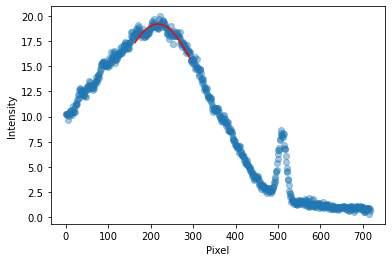

downup sweep, 300 pulse pairs, -170 detuning, -184.16613830295276 m/s
Hessian value: 3.8394847688991147
Chisquare: 26.515732648041684
Uncertainty: 203.61350327671408
+Error: 53, -Error: -22
[216.93560563 200.          18.72951926   0.5       ]


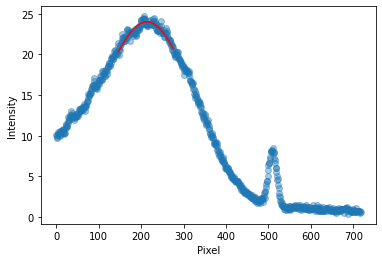

downup sweep, 300 pulse pairs, -150 detuning, -162.49953379672303 m/s
Hessian value: 1.142824968843246
Chisquare: 27.0943246111856
Uncertainty: 61.928141359213946
+Error: 48, -Error: -27
[213.45049866 200.          23.518075     0.5       ]


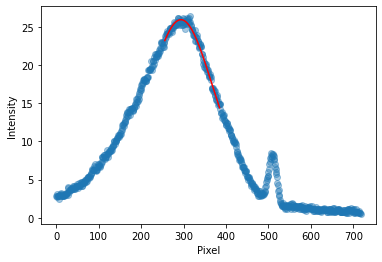

downup sweep, 300 pulse pairs, -130 detuning, -140.8329292904933 m/s
Hessian value: 0.7261686777139365
Chisquare: 21.92817460016824
Uncertainty: 31.847107108169
+Error: 28, -Error: -26
[293.88304609 141.74017153  25.453984     0.49372051]


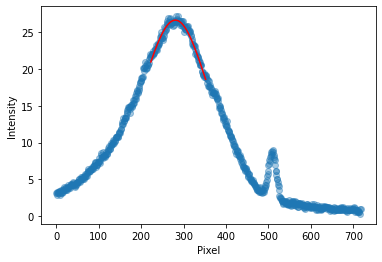

downup sweep, 300 pulse pairs, -10 detuning, -10.83330225311487 m/s
Hessian value: 2.2835648492236773
Chisquare: 20.84218738408721
Uncertainty: 95.18897298246948
+Error: 31, -Error: -25
[280.6975817  148.06157572  26.67160377   0.        ]


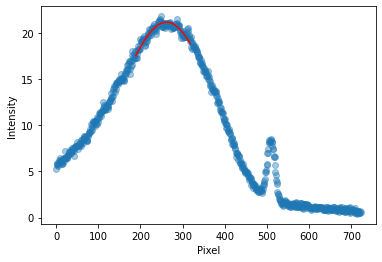

updown sweep, 300 pulse pairs, 10 detuning, 10.83330225311487 m/s
Hessian value: 6.052207835342626
Chisquare: 19.779364541183696
Uncertainty: 239.41765010850014
+Error: 40, -Error: -40
[261.496985   200.          20.66493593   0.5       ]


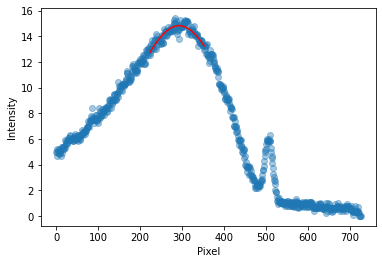

upup sweep, 300 pulse pairs, -30 detuning, -32.499906759344604 m/s
Hessian value: 34.04798024486281
Chisquare: 12.428125028119954
Uncertainty: 846.3051108762265
+Error: 45, -Error: -40
[293.25556106 200.          14.31939584   0.5       ]


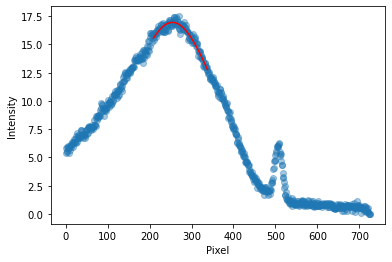

upup sweep, 300 pulse pairs, -10 detuning, -10.83330225311487 m/s
Hessian value: 3.741162404905684
Chisquare: 11.20191987026432
Uncertainty: 83.81640296279767
+Error: 35, -Error: -38
[254.27637555 182.35785787  16.95815237   0.        ]


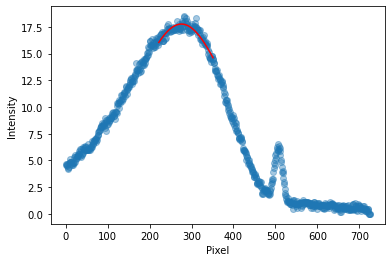

upup sweep, 300 pulse pairs, 10 detuning, 10.83330225311487 m/s
Hessian value: 3.173912292337554
Chisquare: 17.379830208469706
Uncertainty: 110.3241134748031
+Error: 45, -Error: -46
[2.75782974e+02 2.00000000e+02 1.76804089e+01 8.87256398e-02]


In [3]:
lineDict = {}
savepath='C:/Users/wahlm/OneDrive/Documents/School/Research/ARP/PubFigs/'

for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        try:
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()
        except:
            lineDict[k1]={}
            lineDict[k1][k2]=pd.DataFrame()
            lineDict[k1][k2]['max']=dfDict[k1][k2].idxmax()
            lineDict[k1][k2]['detuning']=lineDict[k1][k2].index.tolist()

fitDict = {}
            
def uglyFun(x,B):
    return  B[3]+ B[2]**np.exp(-(x-B[0])**2/(2*B[1]**2))



def uglyChi2(B, args):
    chi2 = 0

# no uncertainties in raw data
    return chi2 + np.sum((uglyFun(args[0],B)-args[1])**2)
 
def gtAll(x,li):
    for num in li:
        if x <= num:
            return False
    return True


for k1,v1 in dfDict.items():
    for k2,v2 in v1.items():
        try:
            fitDict[k1][k2]=pd.DataFrame()
        except:
            fitDict[k1]={}
            fitDict[k1][k2]=pd.DataFrame()
        for detun in dfDict[k1][k2].columns:
            guess = [dfDict[k1][k2][detun].idxmax(), 100,15,0]            
            if guess[0]<400:
                bounds = [(guess[0]-40,guess[0]+40),(1,200),(5,100),(0,.5)]            
                xData=dfDict[k1][k2].index.tolist()[int(guess[0])-60:int(guess[0])+70]
                yData=dfDict[k1][k2][detun].tolist()[int(guess[0])-60:int(guess[0])+70]
            else:
                bounds = [(guess[0]-15,guess[0]+15),(1,200),(5,100),(0,.5)]            
                xData=dfDict[k1][k2].index.tolist()[int(guess[0])-35:int(guess[0])+35]
                yData=dfDict[k1][k2][detun].tolist()[int(guess[0])-35:int(guess[0])+35]
            result=minimize(uglyChi2, guess, bounds = bounds, args=([xData,yData]))
            peak=result.x[0]
            
            plusErr=0
            minErr=0
            cutoff=.95*(result.x[2]+result.x[3])
            buffer=5
            while not gtAll(cutoff,dfDict[k1][k2][detun].tolist()[int(peak)+plusErr:int(peak)+plusErr+buffer+1]):

                
                plusErr+=1
                
            while not gtAll(cutoff,dfDict[k1][k2][detun].tolist()[int(peak)+minErr-buffer-1:int(peak)+minErr]):
                minErr-=1
                
            
            
            baseline=506
            conversion=17.45138889
            k=5.79988*10**6/(2*np.pi)
            unc = 2*result.hess_inv.todense()[0][0]*uglyChi2(result.x,[xData,yData])
#             fitDict[k1][k2]=pd.concat([fitDict[k1][k2],
#                 pd.DataFrame({
#                 'peak':peak,
#                 'posunc':plusErr,
#                 'negunc':minErr,
#                 'detuning':detun,
#                 'height':baseline-peak,
#                 }, index=[0])], 
#                     ignore_index=True)
            
            fitDict[k1][k2]=pd.concat([fitDict[k1][k2],
                pd.DataFrame({
                'peak':peak,
                'posunc':plusErr/conversion,
                'negunc':minErr/conversion,
                'detuning':detun,
                'height':(baseline-peak)/conversion,
                'velocity':detun*10**6/k
                }, index=[0])], 
                    ignore_index=True)
# #             For checking my fitting work
#             if peak < 300:
#                 f, ax=plt.subplots(1,1)
#                 plt.scatter(dfDict[k1][k2].index.tolist(),dfDict[k1][k2][detun], alpha = .4)
#                 xaxs= np.linspace(min(xData),max(xData),1000)
#                 plt.plot(xaxs,uglyFun(xaxs,result.x),'r-')
#                 ax.set_ylabel('Intensity')
#                 ax.set_xlabel('Pixel')
# #                 plt.hlines(cutoff, int(peak)+2*minErr, int(peak)+2*plusErr,colors='k')
#                 plt.show()
#                 f.savefig(savepath+f'{k1}sweep{k2}pp{-detun*10**6/k:.0f}mps.png', dpi=300,bbox_inches='tight', format='png')
#                 print(f'{k1} sweep, {k2} pulse pairs, {detun} detuning, {detun*10**6/k} m/s')
#                 print(f'Hessian value: {result.hess_inv.todense()[0][0]}')
#                 print(f'Chisquare: {uglyChi2(result.x,[xData,yData])}')
#                 print(f'Uncertainty: {unc}')
#                 print(f'+Error: {plusErr}, -Error: {minErr}')
#                 print(result.x)
#issues: updown 300, upup 300, downup 300 have triple peaks
#resolve double peaks
#parameterize by noise

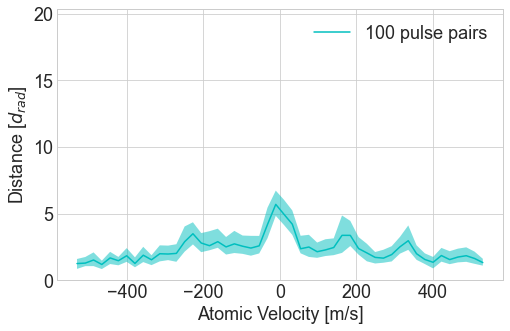

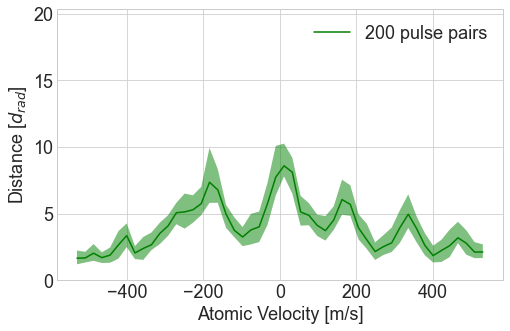

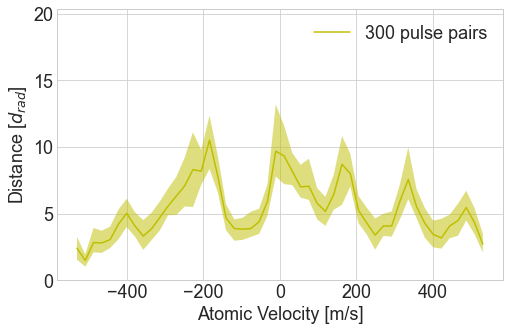

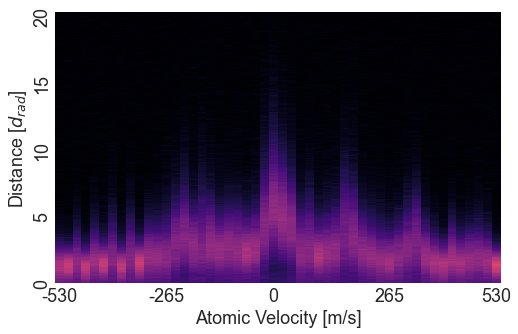

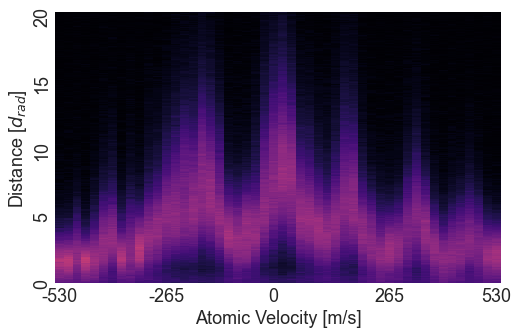

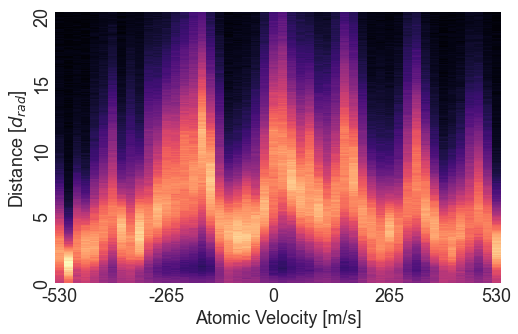

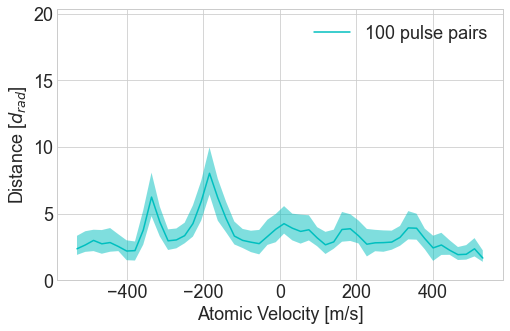

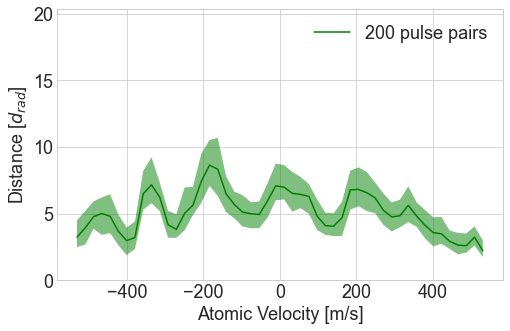

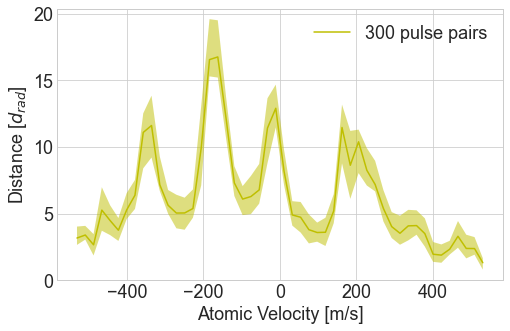

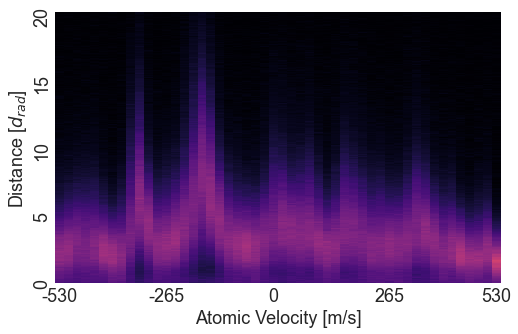

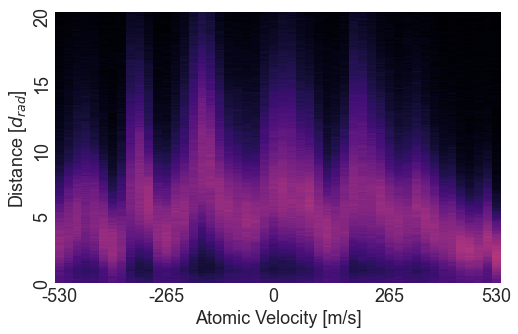

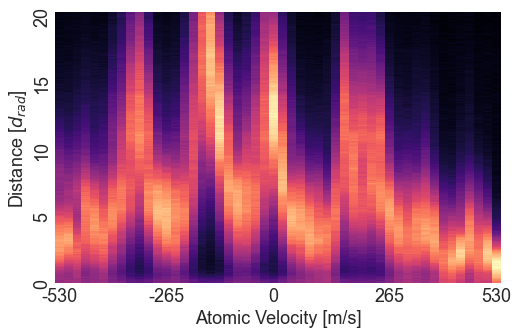

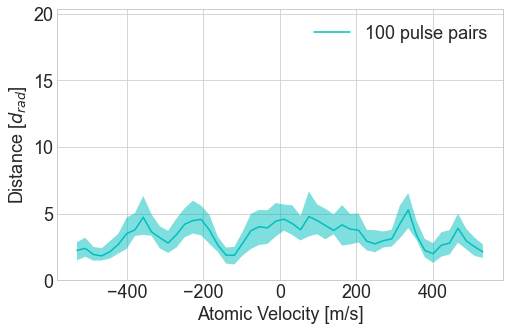

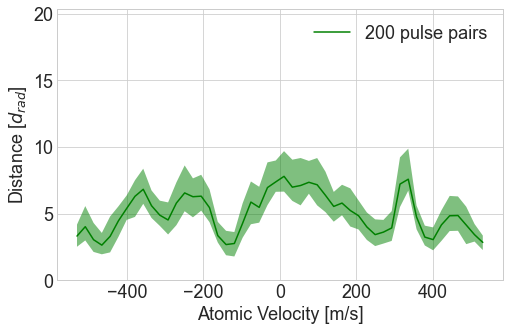

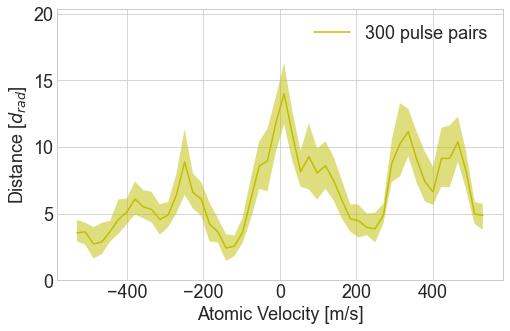

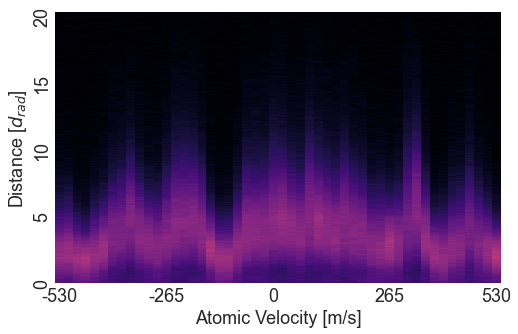

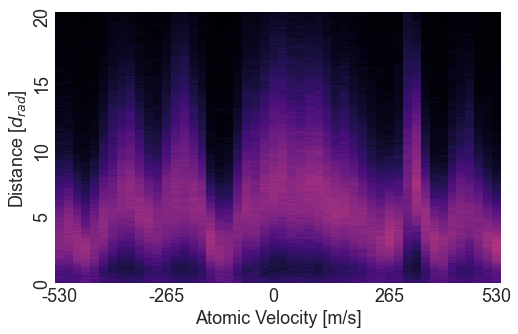

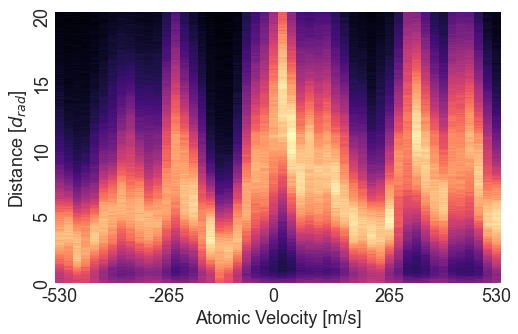

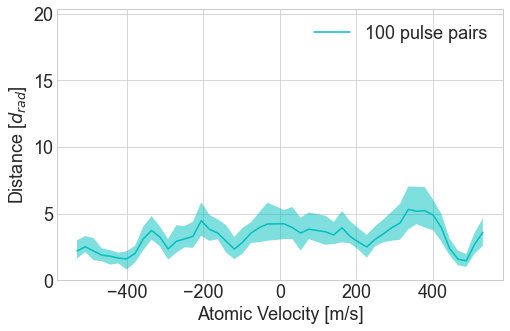

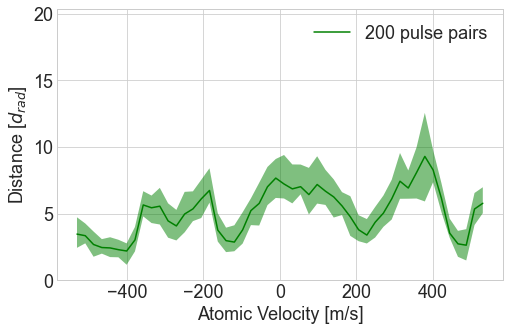

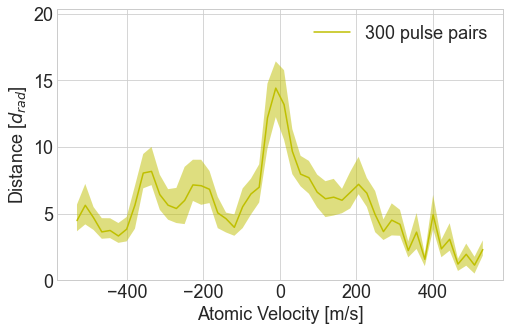

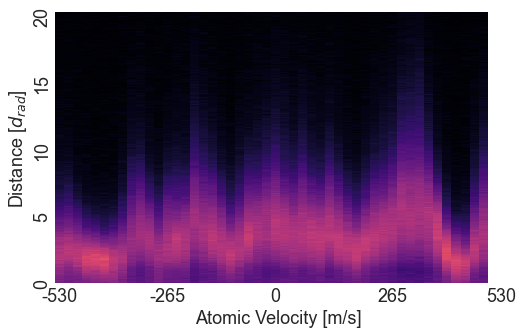

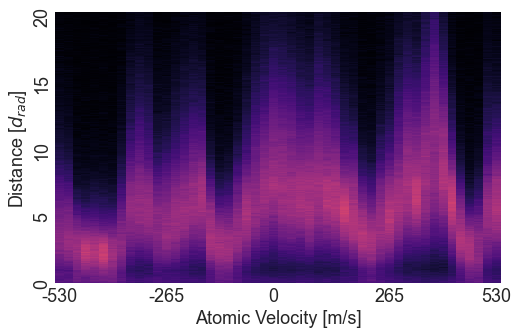

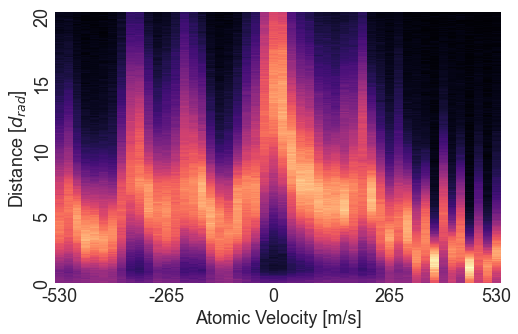

In [15]:
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=18)

path='C:/Users/wahlm/OneDrive/Documents/School/Research/ARP/PubFigs/'
pps=['100','200','300']
colors=['c','g','y','r']
for sweep in ['downdown','downup','updown','upup']:

#     f, axs= plt.subplots(4,2,figsize=(16,20))
#     f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        savepath=path+f'{sweep}_{pp}_lineplot.png'
        f, axs= plt.subplots(1,1,figsize=(8,5))

        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        axs.set_ylabel(r'Distance [$d_{rad}$]')
        
        axs.set_xlabel(r'Atomic Velocity [m/s]')

        axs.set_ylim([0,(baseline-150)/conversion])

        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
        axs.fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)
#         f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
#         plt.show()

    for num, pp in enumerate(pps):
#         f, axs= plt.subplots(1,1,figsize=(16,9))
        
#         sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)

#         x=fitDict[sweep][pp]['velocity']
#         y=fitDict[sweep][pp]['height']
#         ypluserr=fitDict[sweep][pp]['posunc']
#         ynegerr=fitDict[sweep][pp]['negunc']
#         axs.fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)
#         plt.show()
        savepath=path+f'{sweep}_{pp}_heatmap.png'
        f, axs= plt.subplots(1,1,figsize=(8,5))

        tickspace=['' for i in range(11)]
        xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']
        tickspace=['' for i in range(25)]
#         print(len(dfDict[sweep][pp]))
        ylabel= np.linspace(baseline/conversion,(baseline-len(dfDict[sweep][pp]))/conversion,len(dfDict[sweep][pp])).tolist()
        for i,x in enumerate(ylabel):
            if x%5<0.055:
                ylabel[i]=round(x)
            else:
                ylabel[i]=''
        sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,yticklabels=ylabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),cbar=False, ax=axs)
        
        axs.set_ylim([baseline,150])
#         axs.set_ylim([0,(baseline-150)/conversion])
        axs.set_ylabel(r'Distance [$d_{rad}$]')
        axs.set_yticklabels(ylabel)
        axs.set_xlabel(r'Atomic Velocity [m/s]')
#         f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')        
#         plt.show()
#     axs[0][0].title.set_text('1')
#     axs[1][0].title.set_text('2')
#     axs[2][0].title.set_text('3')
#     axs[3][0].title.set_text('a')
    
#     axs[0][1].title.set_text('4')
#     axs[1][1].title.set_text('5')
#     axs[2][1].title.set_text('6')
#     axs[3][1].title.set_text('b')
#     plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.15, 
#                     hspace=0.3)
#     plt.show()
    
#     f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')


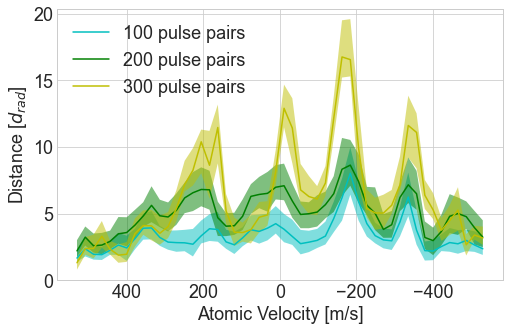

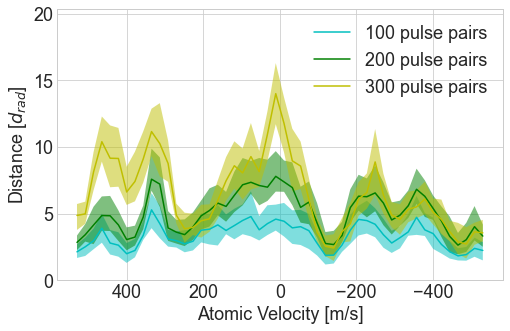

In [27]:
pps=['100','200','300']
colors=['c','g','y','r']
for sweep in ['downup','updown']:
    f, axs= plt.subplots(1,1,figsize=(8,5))
    for num, pp in enumerate(pps):
        savepath=path+f'{sweep}_overlay_flipped_lineplot.png'
        sns.lineplot(x=fitDict[sweep][pp]['velocity'],y=fitDict[sweep][pp]['height'],color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
        axs.fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)
    axs.invert_xaxis()
    axs.set_ylabel(r'Distance [$d_{rad}$]')

    axs.set_xlabel(r'Atomic Velocity [m/s]')

    axs.set_ylim([0,(baseline-150)/conversion])

    
    f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
#     plt.show()

#     for num, pp in enumerate(pps):

#         savepath=path+f'{sweep}_{pp}_heatmap.png'
#         f, axs= plt.subplots(1,1,figsize=(8,5))

#         tickspace=['' for i in range(11)]
#         xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']
#         tickspace=['' for i in range(25)]
#         ylabel= np.linspace(baseline/conversion,(baseline-len(dfDict[sweep][pp]))/conversion,len(dfDict[sweep][pp])).tolist()
#         for i,x in enumerate(ylabel):
#             if x%5<0.055:
#                 ylabel[i]=round(x)
#             else:
#                 ylabel[i]=''
#         sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,yticklabels=ylabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),cbar=False, ax=axs)
        
#         axs.set_ylim([baseline,150])
# #         axs.set_ylim([0,(baseline-150)/conversion])
#         axs.set_ylabel(r'Distance [$d_{rad}$]')
#         axs.set_yticklabels(ylabel)
#         axs.set_xlabel(r'Atomic Velocity [m/s]')
# #         f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')        
#         plt.show()



In [ ]:
ranges={'downdown':[(-250,-150),(-30,30),(110,190),(250,370)], 
       'downup':[(-390,-250),(-210,110),(-50,50),(110,210),(290,390)],
       'updown':[(-390,-290),(-290,-150),(-30,30),(50,110),(250,370),(370,490)],
       'upup':[(-390,-250),(-250,-150),(-30,30)]}
peaks={}
for sweep in ['downdown','downup','updown','upup']:
    peaks[sweep]={}
    for num, pp in enumerate(['100','200','300']):
        peaks[sweep][pp]=[]
        for a,b in ranges[sweep]:
            cut=fitDict[sweep][pp].loc[(a<=fitDict[sweep][pp]['detuning'])&(b>=fitDict[sweep][pp]['detuning'])]
            peakrow=cut[cut.height==cut.height.max()]
            peaks[sweep][pp].append((int(peakrow['detuning']),float(peakrow['height'])))
            
# print(peaks['updown'])

In [ ]:
pspacings={}
pheights={}
for sweep in ['downdown','downup','updown','upup']:
    pspacings[sweep]={}
    pheights[sweep]={}

    for pp in ['100','200','300']:
        spacing=[]
        height=[]
        for d,h in peaks[sweep][pp]:
            spacing.append(d)
            height.append(h)
        
        spacelist=[]
        for i in range(len(spacing)-1):
            spacelist.append(spacing[i+1]-spacing[i])
                                     
        pspacings[sweep][pp]=spacelist
        pheights[sweep][pp]=height

In [ ]:
# f, ax =plt.subplots()
colors=['r','g','b','k']
for i, sweep in enumerate(['downdown','downup','updown','upup']):
    histarr=[]
    savepath=path+sweep+'spacing.png'
    for pp in ['100','200','300']:
        histarr+=pspacings[sweep][pp]
        
    histarr=np.array(histarr)/k*10**6
    print(np.mean(histarr),np.std(histarr))
    f, ax =plt.subplots()
    binning=[x for x in range(50,300,25)]
#     ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5, label=f'{sweep} Sweep')
    ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5)
    ax.set_xlabel('Spacing of Adjacent Peaks [m/s]')
    ax.set_ylabel('Count')
#     ax.legend(loc='upper left')
    f.savefig(savepath, dpi=300,bbox_inches='tight', format='png')
    plt.show()

In [ ]:
f, ax =plt.subplots()
colors=['r','g','b','k']
histarr=[]
savepath=path+'totalspacing.png'
for i, sweep in enumerate(['downdown','downup','updown','upup']):

    
    for pp in ['100','200','300']:
        histarr+=pspacings[sweep][pp]
mx=max(histarr)
mn=min(histarr)
histarr=[i for i in histarr if i!=mx and i!= mn]
print(len(histarr))
histarr=np.array(histarr)/k*10**6


print(np.mean(histarr),np.std(histarr))

#     f, ax =plt.subplots()
binning=[x for x in range(50,300,25)]
#     ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[i], alpha=.5, label=f'{sweep} Sweep')
ax.hist(histarr, bins=binning, histtype='barstacked', color=colors[0], alpha=.5)
ax.set_xlabel('Spacing of Adjacent Peaks [m/s]')
ax.set_ylabel('Count')
#     ax.legend(loc='upper left')
ax.title.set_text('c')
f.savefig(savepath, dpi=1000,bbox_inches='tight', format='png')

In [ ]:
# colors=['r','g','b','k']
# histdict={}

# for i, sweep in enumerate(['downdown','downup','updown','upup']):
#     stdev=0
#     histdict[sweep]=np.zeros()
#     for pp in ['100','200','300']:
#         for h in pheights[sweep][pp]:
            
#         histdict{sweep}+=pheights[sweep][pp]
colors=['r','g','b','k']
histdict={}
meanheights={}

for i, sweep in enumerate(['downdown','downup','updown','upup']):
    meanheights[sweep]={}
    for pp in ['100','200','300']:
        harr=np.array(pheights[sweep][pp])
        meanheights[sweep][pp]=(np.mean(harr),np.std(harr))

In [ ]:
plt.style.use('seaborn-whitegrid')
pps=['100','200','300']
colors=['c','g','y','r']
f, axs= plt.subplots(1,1,figsize=(10,6))
# f.suptitle('Normalized Mean Peak Height by Sweep Direction and Pulse Pair',fontsize=20)

x = np.arange(4)
xlabel=['Down/Down','Down/Up','Up/Down','Up/Up']
barwidth=.1
for num, pp in enumerate(pps):
    y=[]
    err=[]
    for sweep in ['downdown','downup','updown','upup']:       
        y.append(meanheights[sweep][pp][0]/float(pp))
        err.append(meanheights[sweep][pp][1]/float(pp))
            
    axs.bar(x + num*barwidth, y,yerr=err,width=barwidth,color=colors[num],
           label=f'{pp} Pulse Pairs')

axs.legend(loc='upper right')
axs.set_xticks(x + barwidth)
axs.set_xticklabels(xlabel) 
axs.set_ylabel('Mean Peak Height/#pp')  
f.savefig(path+'peakheight.png', dpi=1000,bbox_inches='tight', format='png')
plt.show()

In [ ]:
plt.style.use('seaborn-whitegrid')
for i,sweep in enumerate(['downdown','downup','updown','upup']):
    
    pps=['100','200','300']
    colors=['c','g','y','r']
    f, axs= plt.subplots(1,1,figsize=(8,5))
    f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
        axs.scatter([loc*10**6/k for loc, hgt in peaks[sweep][pp]],[hgt for loc, hgt in peaks[sweep][pp]])



    plt.show()


In [ ]:
plt.style.use('seaborn-whitegrid')
pps=['300']
colors=['c','g','y','r']

# f, axs= plt.subplots(1,2,figsize=(8,5))
# sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs)
# axs.set_ylabel(r'Force [$F_{rad}$]')

for sweep in ['updown']:
    savepath=path+sweep+'sing.png'

    f, axs= plt.subplots(1,2,figsize=(16,5))
#     f.suptitle(f'{sweep} sweep',fontsize=20)

    for num, pp in enumerate(pps):
        sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[0])
#         sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[0][1])
        axs[0].set_ylabel(r'Force [$F_{rad}$]')
        
        axs[0].set_xlabel(r'Atomic Velocity [m/s]')

        
        axs[0].set_ylim([0,(baseline-150)/conversion])
#         axs[0][1].set_ylim([0,(baseline-150)/conversion])
        x=fitDict[sweep][pp]['velocity']
        y=fitDict[sweep][pp]['height']
        ypluserr=fitDict[sweep][pp]['posunc']
        ynegerr=fitDict[sweep][pp]['negunc']
        axs[0].fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)

    for num, pp in enumerate(pps):
#         sns.lineplot(x='velocity',y='height',data=fitDict[sweep][pp], color=colors[num],label=f'{pp} pulse pairs',ax=axs[num+1][0])

#         x=fitDict[sweep][pp]['velocity']
#         y=fitDict[sweep][pp]['height']
#         ypluserr=fitDict[sweep][pp]['posunc']
#         ynegerr=fitDict[sweep][pp]['negunc']
#         axs[num+1][0].fill_between(x, y+ynegerr, y+ypluserr,facecolor=colors[num],alpha=0.5)

        
        tickspace=['' for i in range(11)]
        xlabel = ['-530']+tickspace+['-265']+tickspace+['0']+tickspace+['','265']+tickspace+['530']

        sns.heatmap(dfDict[sweep][pp], xticklabels=xlabel,vmin=0, vmax = dfDict[sweep]['300'].max().max(),cmap=sns.color_palette("magma", as_cmap=True),yticklabels=False,cbar=False, ax=axs[1])
        
        axs[1].set_ylim([baseline,150])
#         axs[num+1][0].set_ylim([0,(baseline-150)/conversion])
#         axs[num+1][0].set_ylabel(r'Force [$F_{rad}$]')
        axs[1].set_ylabel(r'Force [$F_{rad}$]')
        axs[1].set_xlabel(r'Atomic Velocity [m/s]')
#         axs[num+1][1].set_xlabel(r'Atomic Velocity [m/s]')

    plt.show()
    f.savefig(savepath, dpi=200,bbox_inches='tight', format='png')
